In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import os,cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tf_explain.core.grad_cam import GradCAM

from skimage import io
import os, random

from keras.preprocessing import image
import keras.utils as image

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [69]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [70]:
train_dataset  = train_datagen.flow_from_directory(directory = './CK+48/',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 788 images belonging to 7 classes.


In [71]:
valid_dataset = valid_datagen.flow_from_directory(directory = './CK+48/',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 193 images belonging to 7 classes.


In [72]:
test_dataset = test_datagen.flow_from_directory(directory = './CK+48/',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 981 images belonging to 7 classes.


(64, 48, 48, 3)


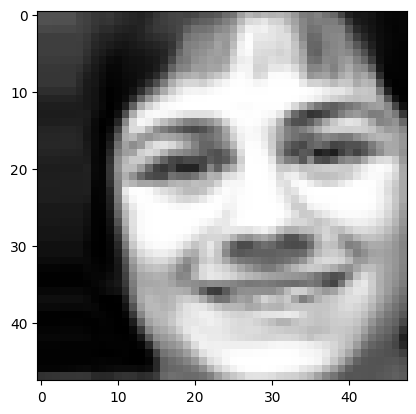

(64, 48, 48, 3)


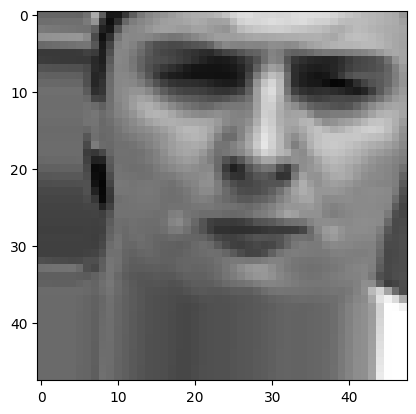

(64, 48, 48, 3)


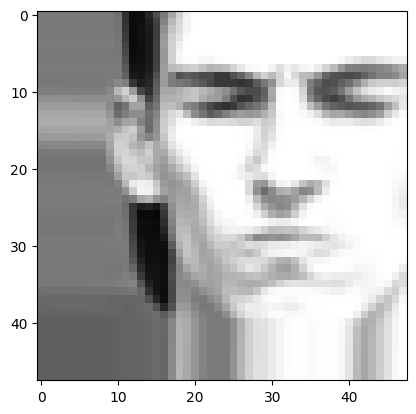

(64, 48, 48, 3)


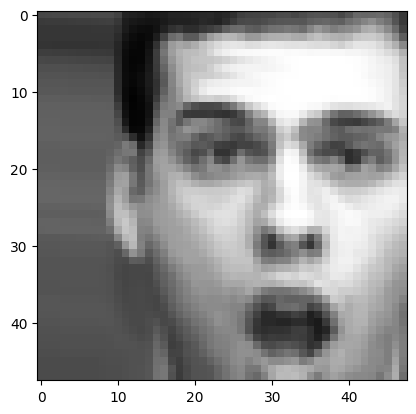

(64, 48, 48, 3)


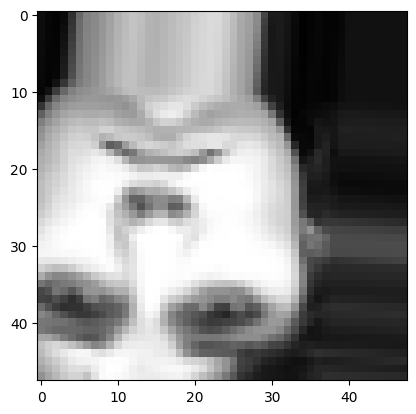

In [92]:
for _ in range(5):
    img, label = train_dataset.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [73]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3), include_top=False, weights="imagenet")


In [74]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [75]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [76]:
# Model Summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_3 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                262176    
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                      

In [77]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [78]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [79]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('resnetCK+.h5')

es = EarlyStopping(verbose=1, patience=20)

In [80]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=METRICS)

In [81]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 100,verbose = 1)

Epoch 1/100
13/13 [==============================] - 45s 2s/step - loss: 2.1796 - accuracy: 0.8522 - precision: 0.2545 - recall: 0.0178 - auc: 0.5147 - f1_score: 0.0311 - val_loss: 2.1790 - val_accuracy: 0.8534 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5362 - val_f1_score: 0.0000e+00
Epoch 2/100
13/13 [==============================] - 7s 542ms/step - loss: 1.9819 - accuracy: 0.8546 - precision: 0.3871 - recall: 0.0305 - auc: 0.5927 - f1_score: 0.0578 - val_loss: 1.9586 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5837 - val_f1_score: 0.0000e+00
Epoch 3/100
13/13 [==============================] - 11s 478ms/step - loss: 1.9350 - accuracy: 0.8564 - precision: 0.4762 - recall: 0.0508 - auc: 0.6040 - f1_score: 0.0959 - val_loss: 1.8483 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6458 - val_f1_score: 0.0000e+00
Epoch 4/100
13/13 [==============================] - 5s 446ms/step -

### Quantitative Evaluation

In [82]:
#EVALUATION

print('Train Accuracy: ', round(history.history['accuracy'][-1],2))
print('Train Loss: ', round(history.history['loss'][-1],2))
print('Train Precision: ', round(history.history['precision'][-1],2))
print('Train Recall: ', round(history.history['recall'][-1],2))
print('Train F1-Score: ', round(history.history['f1_score'][-1],2))

Train Accuracy:  0.87
Train Loss:  1.53
Train Precision:  0.67
Train Recall:  0.16
Train F1-Score:  0.26


In [83]:
#EVALUATION

print('Test Accuracy: ', round(history.history['val_accuracy'][-1],2))
print('Test Loss: ', round(history.history['val_loss'][-1],2))
print('Test Precision: ', round(history.history['val_precision'][-1],2))
print('Test Recall: ', round(history.history['val_recall'][-1],2))
print('Test F1-Score: ', round(history.history['val_f1_score'][-1],2))

Test Accuracy:  0.86
Test Loss:  1.67
Test Precision:  0.54
Test Recall:  0.33
Test F1-Score:  0.31


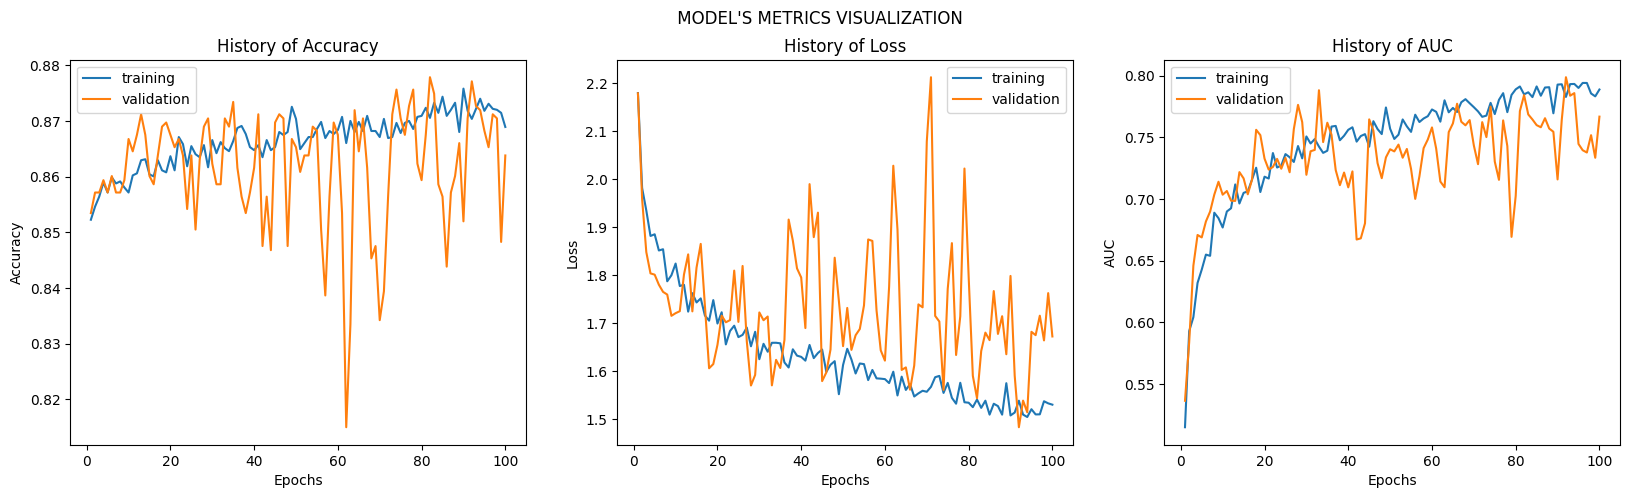

In [84]:
#%% PLOTTING RESULTS (Train vs Validation)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc):
    
    fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
             
              )

### Hyperparameter tuning


In [85]:
# Tuned parameters
epochs = 200
callbacks = [ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10),ModelCheckpoint('resnetCK+.h5')]
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('resnetCK+.h5')
es = EarlyStopping(verbose=1, patience=20)

In [86]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = epochs,verbose = 1,callbacks=callbacks)

Epoch 1/200
13/13 [==============================] - 11s 937ms/step - loss: 1.5293 - accuracy: 0.8718 - precision: 0.7341 - recall: 0.1612 - auc: 0.7871 - f1_score: 0.2699 - val_loss: 1.6639 - val_accuracy: 0.8468 - val_precision: 0.4167 - val_recall: 0.1813 - val_auc: 0.7556 - val_f1_score: 0.4352 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 3s 204ms/step - loss: 1.5284 - accuracy: 0.8697 - precision: 0.6845 - recall: 0.1624 - auc: 0.7897 - f1_score: 0.2676 - val_loss: 1.6582 - val_accuracy: 0.8712 - val_precision: 0.7436 - val_recall: 0.1503 - val_auc: 0.7272 - val_f1_score: 0.1869 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 2s 180ms/step - loss: 1.5014 - accuracy: 0.8736 - precision: 0.7358 - recall: 0.1802 - auc: 0.7962 - f1_score: 0.2943 - val_loss: 1.5486 - val_accuracy: 0.8712 - val_precision: 0.8519 - val_recall: 0.1192 - val_auc: 0.7768 - val_f1_score: 0.1543 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 1s 98ms/st

### Quantitative Evaluation

In [87]:
#EVALUATION

print('Train Accuracy: ', round(history.history['accuracy'][-1],2))
print('Train Loss: ', round(history.history['loss'][-1],2))
print('Train Precision: ', round(history.history['precision'][-1],2))
print('Train Recall: ', round(history.history['recall'][-1],2))
print('Train F1-Score: ', round(history.history['f1_score'][-1],2))

Train Accuracy:  0.89
Train Loss:  1.33
Train Precision:  0.76
Train Recall:  0.28
Train F1-Score:  0.41


In [88]:
#EVALUATION

print('Test Accuracy: ', round(history.history['val_accuracy'][-1],2))
print('Test Loss: ', round(history.history['val_loss'][-1],2))
print('Test Precision: ', round(history.history['val_precision'][-1],2))
print('Test Recall: ', round(history.history['val_recall'][-1],2))
print('Test F1-Score: ', round(history.history['val_f1_score'][-1],2))

Test Accuracy:  0.88
Test Loss:  1.41
Test Precision:  0.75
Test Recall:  0.26
Test F1-Score:  0.53


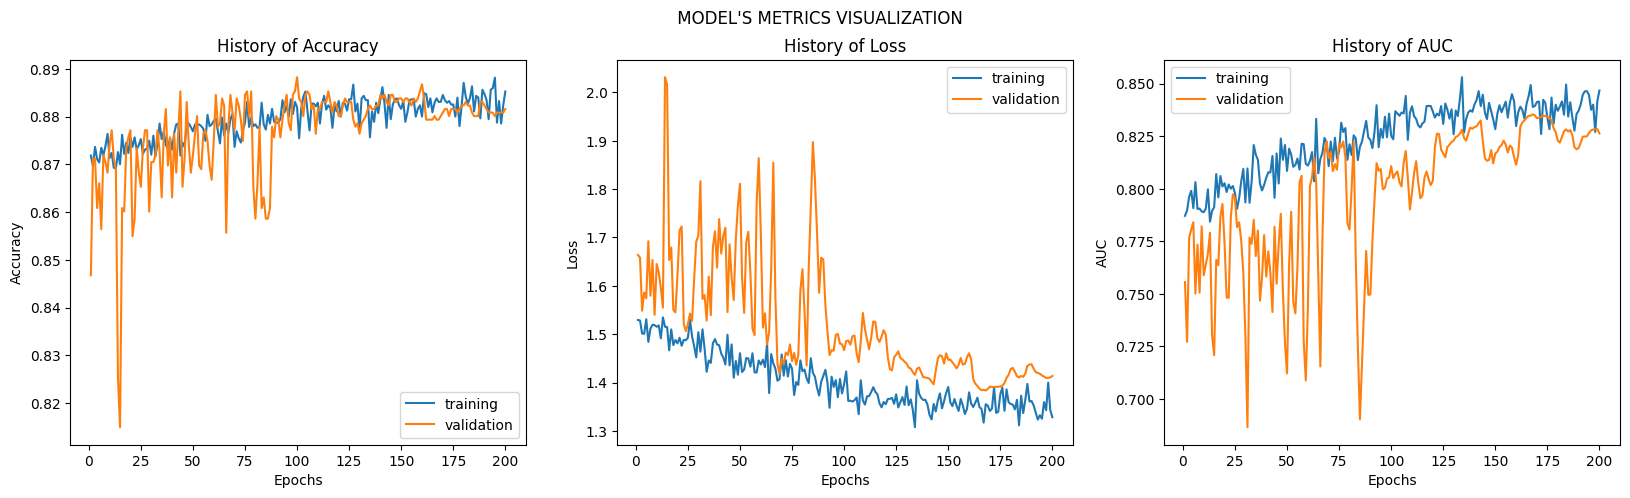

In [89]:
#%% PLOTTING RESULTS (Train vs Validation)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc):
    
    fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
             
              )

### Qualitative Evaluation

1/1 [==============================] - 5s 5s/step


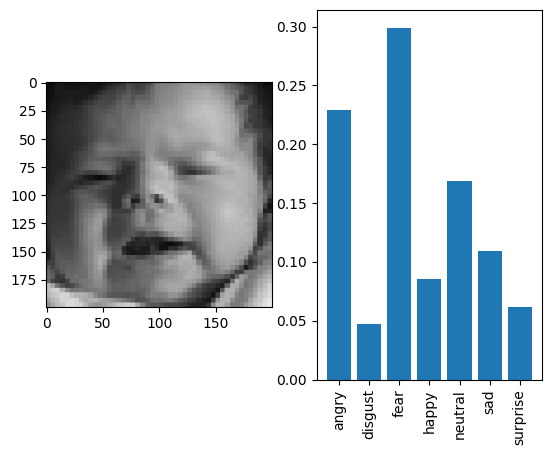

Expression Prediction: fear
1/1 [==============================] - 0s 34ms/step


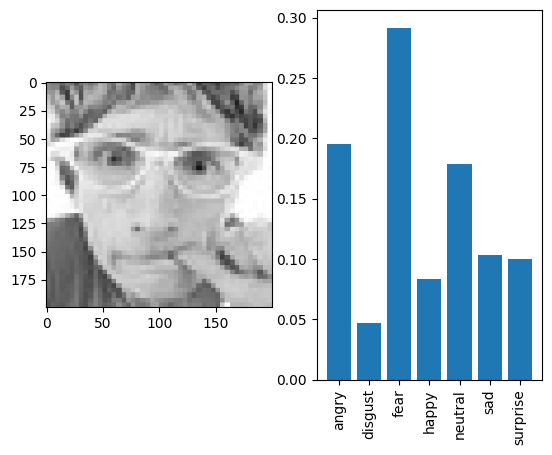

Expression Prediction: fear
1/1 [==============================] - 0s 34ms/step


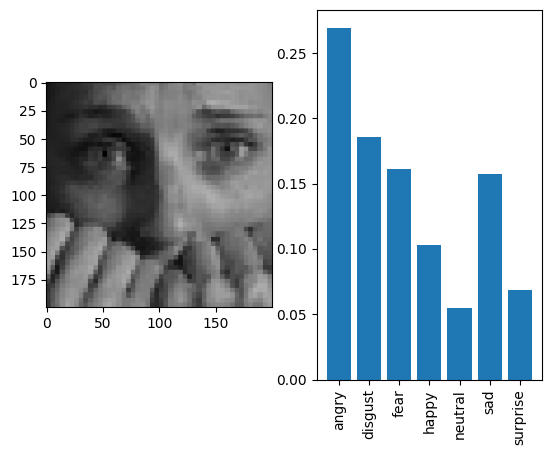

Expression Prediction: angry
1/1 [==============================] - 0s 20ms/step


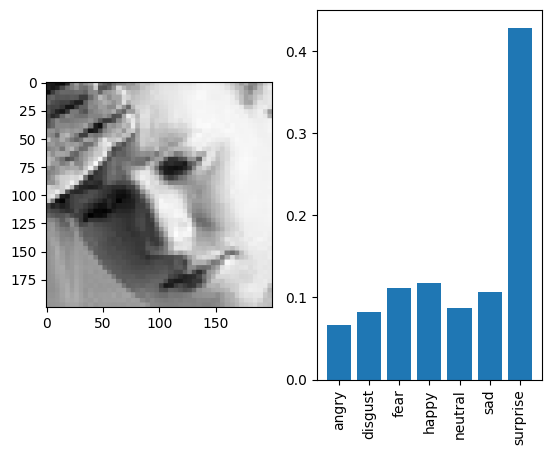

Expression Prediction: surprise
1/1 [==============================] - 0s 62ms/step


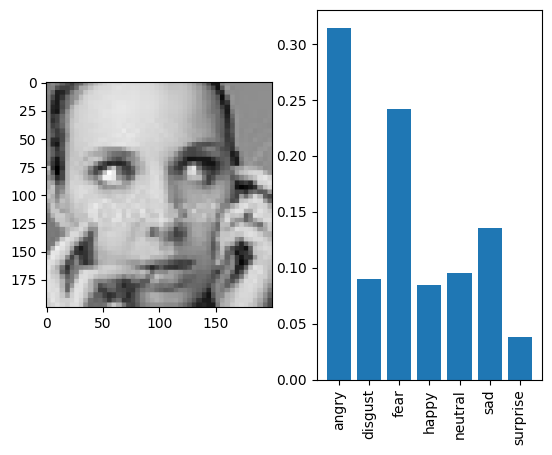

Expression Prediction: angry
1/1 [==============================] - 0s 21ms/step


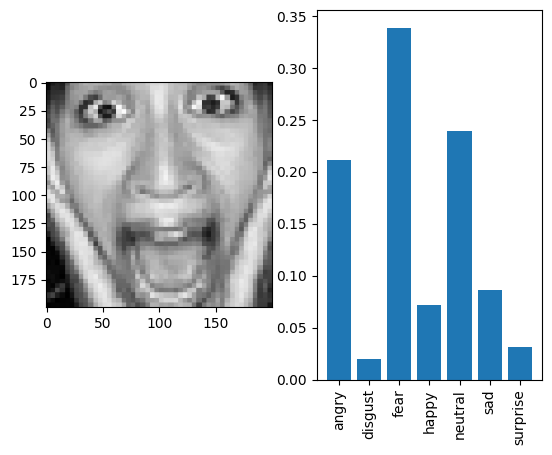

Expression Prediction: fear
1/1 [==============================] - 0s 49ms/step


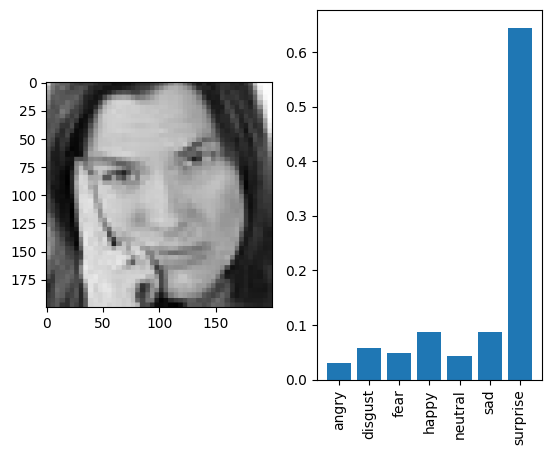

Expression Prediction: surprise
1/1 [==============================] - 0s 84ms/step


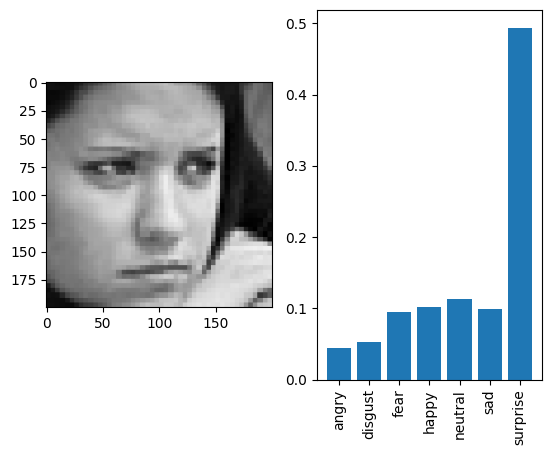

Expression Prediction: surprise
1/1 [==============================] - 0s 39ms/step


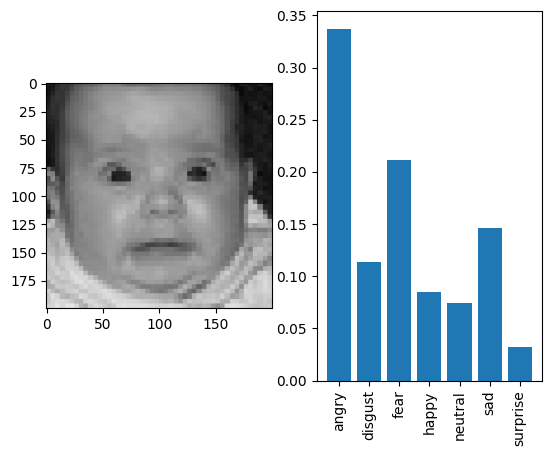

Expression Prediction: angry
1/1 [==============================] - 0s 130ms/step


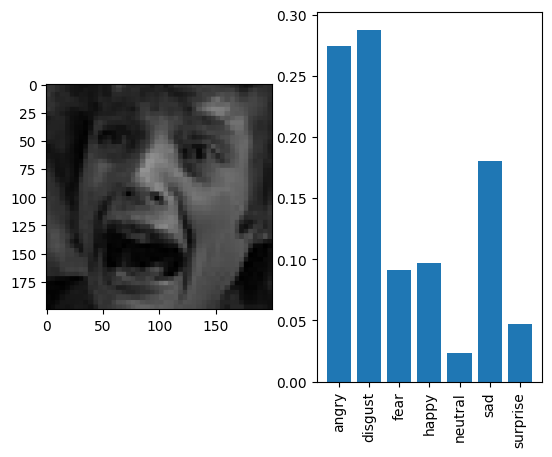

Expression Prediction: disgust


In [90]:
objects = ('angry','disgust','fear','happy','neutral','sad','surprise')
for i in range(0,10):
    randimg = random.choice(os.listdir("./FER2013 - Images/test/fear"))
    randimgpath = "./FER2013 - Images/test/fear/" + randimg
    img = image.load_img(randimgpath, target_size = (48, 48))
    show_img = image.load_img(randimgpath, target_size = (200, 200))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)

    x /= 255
    custom = model.predict(x)
  
    x = np.array(x, 'float32')
    x = x.reshape([48, 48,3]);

    plt.gray()
    plt.subplot(1,2,1)
    plt.imshow(show_img)
    
    plt.subplot(1,2,2)
    plt.bar(objects,custom[0])
    plt.xticks(rotation=90)
    
    plt.show()

    a = custom[0]
    m = a[0]
    for i in range(0,len(a)):
        if a[i] >= m:
            m = a[i]
            ind = i

    print('Expression Prediction:',objects[ind])

4/4 [==============================] - 11s 173ms/step
Confusion matrix, without normalization
[[ 5  1  7  0  6  0  8]
 [ 1  0  4  0  5  0  0]
 [ 5  1 11  0 10  0  8]
 [ 2  0  6  0  4  0  3]
 [ 4  0 12  0  8  0 17]
 [ 1  0  6  0  4  0  5]
 [ 3  0 13  0 18  0 15]]


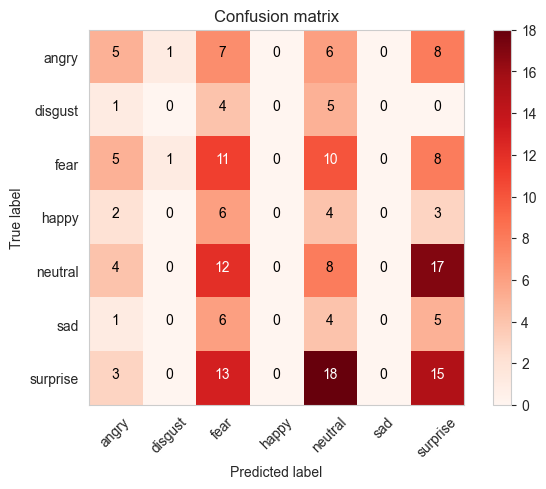

In [95]:
import seaborn as sns
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap='viridis'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_true = valid_dataset.classes
y_hat =  model.predict(valid_dataset)
y_hat = tf.argmax(y_hat, axis = 1).numpy()
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_true, y_pred = y_hat)
plot_confusion_matrix(cm, classes, cmap = 'Reds')
plt.savefig('confmat.png')